# Table of contents

### - Import libraries and define functions + Initial setup

### - Pre-process data

### - Make figures

# Import libraries and define functions + Initial setup

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(dff):
    
    ## Create copy to avoid altering orignal dataframe
    dff = df.copy()
    
    ## Group by gene_id and get total expression for each gene (not counting introns)
    dff_sums = dff[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    dff_sums["total_CPM_gene"] = dff_sums["total_CPM"]
    dff_sums.drop(columns="total_CPM", inplace=True)
    
    ## Merge dataframe with total gene level CPM with regular transcript level CPM dataframe
    merged_dff = pd.merge(dff, dff_sums, how='inner', on="gene_id")
    
    ## Calculater relative percent abundance for each transcript within its gene
    merged_dff["relative_abundance_percent"] = ((merged_dff["total_CPM"]/merged_dff["total_CPM_gene"]) * 100)
    
    ## Rename total_CPM for transcript column
    merged_dff["total_CPM_transcript"] = merged_dff["total_CPM"]
    merged_dff.drop(columns="total_CPM", inplace=True)


    return merged_dff

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Create copy to avoid altering orignal dataframe
    dff = df.copy()
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = dff.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        dff["gene_id"] = dff.index
        cols = list(dff.columns)
        cols = [cols[-1]] + cols[:-1]
        dff = dff[cols]
        dff.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = dff.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    dff.columns = list_new_names
    
    return dff 

In [4]:
'''
function name: parse_dff_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False, delete_other=True):
   
    ## Create copy to avoid altering orignal dataframe
    dff = df.copy()
    
    if is_ref:

        ## Get gene ids
        dff["gene_id"] = dff["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        dff["gene_name"] = dff["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        dff["gene_biotype"] = dff["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            dff["transcript_id"] = dff["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            dff["transcript_biotype"] = dff["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                dff["protein_id"] = dff["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                dff["ccds_id"] = dff["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                dff["exon_number"] = dff["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        dff.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        dff["gene_id"] = dff["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        dff["transcript_id"] = dff["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        dff["exon_number"] = dff["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        if delete_other:
            dff.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in dff.columns:
        dff.loc[dff[col].isnull(), col] = np.NaN
        

    return dff

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):
    
    ## Create copy to avoid altering orignal dataframe
    dff = df.copy()

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = dff.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = dff.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        dff[col] = round(dff[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        dff[cpm_name] = round(((dff[col]/(dff[col].sum())) * 1000000), 2)
    
    return dff  

In [6]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

## - Pre-process data

In [7]:
## Open original reference
original_ref = pd.read_csv("../../../references/Homo_sapiens.GRCh38.107_ERCC.gtf", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")

original_ref = original_ref.loc[~original_ref["chr"].str.startswith("ERCC-")]

## Parse through reference to get gene names and ids
orig_t_ref = original_ref.loc[original_ref["type"]=="transcript"].copy()
orig_t_ref = parse_df_columns(orig_t_ref, is_ref=True, is_transcript=True)

In [8]:
## Import data for transcript level counts and fix column names

df = pd.read_csv("../../../data/raw/nextflow_pipeline_output/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df = fix_column_names(df, is_gene=False)

## Calculate CPM and drop count columns
df = calculate_cpm(df, is_gene=False)

df = df[df.columns.drop(list(df.filter(regex='counts')))].copy()


## Drop ERCCs
df = df.loc[~df["gene_id"].str.startswith("ERCC")].copy()

## Calculate median CPM
df["median_CPM"] = df[df.filter(regex='[0-9]_CPM').columns].median(axis=1)

In [9]:
## Add transcript biotype

df = df.merge(orig_t_ref[["transcript_id", "transcript_biotype"]], how="left", on="transcript_id")

df["transcript_biotype"].fillna("new_transcript", inplace=True)

In [10]:
## Create "other" transcript biotype

keep_list = ["protein_coding", "lncRNA", "retained_intron",]

df.loc[~df["transcript_biotype"].isin(keep_list), "transcript_biotype"] = "other"

## - Make Plots

In [11]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []

list_prot = []
list_lncRNA = []
list_intron = []
list_other = []

for i in range(0, 1001):
    
    cpm_thresh = i/100
    
    df2 = df.loc[df["median_CPM"] >= cpm_thresh].copy()
    
    num_prot = df2.loc[df2["transcript_biotype"] == "protein_coding"].shape[0]
    num_lncRNA = df2.loc[df2["transcript_biotype"] == "lncRNA"].shape[0]
    num_intron = df2.loc[df2["transcript_biotype"] == "retained_intron"].shape[0]
    num_other = df2.loc[df2["transcript_biotype"] == "other"].shape[0]

    list_cpm_thresh.append(cpm_thresh)
    
    list_prot.append(num_prot)
    list_lncRNA.append(num_lncRNA)
    list_intron.append(num_intron)
    list_other.append(num_other)

In [12]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in inches
rcParams['figure.figsize'] = (85*mm, 85*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

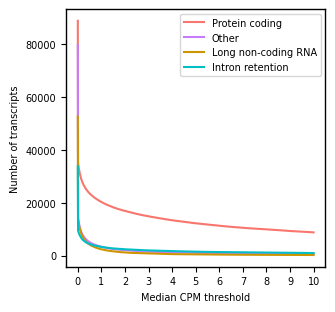

In [13]:
## Make plot showing number of different CDS transcripts from genes expressing 2+ Transcripts with a different CDS

plt.plot(list_cpm_thresh, list_prot, color=ggplot2_colors[0], label="Protein coding", linewidth=1.5, alpha=1)
plt.plot(list_cpm_thresh, list_other, color=ggplot2_colors[6], label="Other", linewidth=1.5, alpha=1)
plt.plot(list_cpm_thresh, list_lncRNA, color=ggplot2_colors[1], label="Long non-coding RNA", linewidth=1.5, alpha=1)
plt.plot(list_cpm_thresh, list_intron, color=ggplot2_colors[4], label="Intron retention", linewidth=1.5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM threshold')
plt.ylabel('Number of transcripts')
plt.legend(loc="upper right", fontsize=7)

plt.savefig('../../../figures/1st_rebuttal_figures/intron_retention/lineplot_transcript_biotype_across_CPM_threshold.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [14]:
data = {"Median CPM Threshold": ["≥0", "≥0", "≥0", "≥0",
                                 "≥1", "≥1", "≥1", "≥1",
                                 "≥2", "≥2", "≥2", "≥2",
                                 "≥5", "≥5", "≥5", "≥5",
                                 "≥10", "≥10", "≥10", "≥10"],
        
       "Transcript biotype": ["Protein coding", "Long non-coding RNA", "Intron retention", "Other", "Protein coding", "Long non-coding RNA", 
                              "Intron retention", "Other", 
                              "Protein coding", "Long non-coding RNA", "Intron retention", "Other", "Protein coding", "Long non-coding RNA", 
                              "Intron retention",  "Other",
                              "Protein coding", "Long non-coding RNA", "Intron retention", "Other"],
       
       "Transcripts (count)": [list_prot[0], list_lncRNA[0], list_intron[0], list_other[0], list_prot[100], list_lncRNA[100], 
                               list_intron[100], list_other[100],
                              list_prot[200], list_lncRNA[200], list_intron[200], list_other[200],
                              list_prot[500], list_lncRNA[500], list_intron[500], list_other[500],
                               list_prot[1000], list_lncRNA[1000], list_intron[1000], list_other[1000]]
       }

df_plot = pd.DataFrame(data=data)

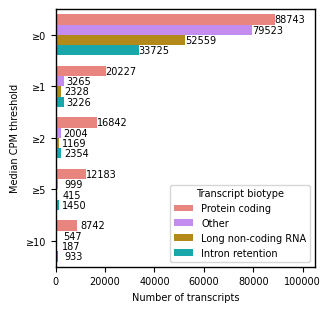

In [15]:
## Make no filter countsplot and save

ax = sns.barplot(y="Median CPM Threshold", x="Transcripts (count)", hue='Transcript biotype', data=df_plot, orient='h',
                  palette=[ggplot2_colors[0], ggplot2_colors[6], ggplot2_colors[1], ggplot2_colors[4]],
                hue_order=["Protein coding", "Other", "Long non-coding RNA", "Intron retention"])


# Adding labels to each bar
for p in ax.patches:
    
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2), 
                ha='center', va='center', 
                xytext=(11, 0), 
                textcoords='offset points',
                fontsize=7)

plt.xlim(0, 105000)
    
plt.ylabel("Median CPM threshold")
plt.xlabel("Number of transcripts")


plt.savefig('../../../figures/1st_rebuttal_figures/intron_retention/barplot_transcript_biotype_across_CPM_threshold.pdf',
            dpi=600, transparent=True, bbox_inches="tight")
